# Load data & libraries

In [284]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
color_pal = sns.color_palette()

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization

In [2]:
df = pd.read_csv("../dataset/interview-test.csv")
df.sort_values(by='salesdate', inplace = True)
df.head(3)

,salesdate,menuid,menuname,menu_group,qty_total
4391,2022-05-16,157,Spicy Gyudon,Spicy Gyudon,1
4383,2022-05-16,272,Sayur Singkong + Telur Barendo - Longboard,0,1
4382,2022-05-16,1,Sei Sapi Matah Regular,Sei Sapi sambal matah,1


- salesdate: the day sales happen
- menuid: menu identification for the menu. (sometimes same menuname not gruanted to have identical menuid)
- menuname: name of the menu. (FS means flash sales, B1G1 means buy 1 get 1, etc)
- qty_total: total of menu ordered

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8902 entries, 4391 to 795
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   salesdate   8902 non-null   object
 1   menuid      8902 non-null   int64 
 2   menuname    8902 non-null   object
 3   menu_group  8902 non-null   object
 4   qty_total   8902 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 417.3+ KB


In [4]:
df.describe(include = ['object','int','float']).T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
salesdate,8902,101,2023-04-08,244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
menuid,8902.0,NaN,NaN,NaN,457.300719,238.769876,1.0,234.0,515.0,638.0,994.0
menuname,8902,370,Plastic Spoon,191,NaN,NaN,NaN,NaN,NaN,NaN,NaN
menu_group,8902,63,0,4665,NaN,NaN,NaN,NaN,NaN,NaN,NaN
qty_total,8902.0,NaN,NaN,NaN,1.132105,0.609869,1.0,1.0,1.0,1.0,21.0


In [5]:
df.shape

(8902, 5)

# EDA

In [6]:
menu_grup_unique = df["menu_group"].unique()
menu_name_unique = df["menuname"].unique()

In [7]:
df['new_col'] = list(zip(df.menu_group, df.menuname))

"""
menu_dict = {menu_group: [menu_name]}. menu dict is used to know how many different menu_name in each menu_group
"""

menu_dict = {}
for menu_zipped in df['new_col'].unique():
    for i,data in enumerate(menu_zipped):
        if(i == 0):
            key = data
            if(key not in menu_dict.keys()):
                menu_dict[key] = list()
        if(i == 1):
            if(data not in menu_dict[key]):
                menu_dict[key].append(data)
df.drop('new_col',axis = 1,inplace = True)

In [8]:
for menu_group,menu_name in menu_dict.items():
    print(f"{menu_group} : {menu_name}", end="\n")

Spicy Gyudon : ['Spicy Gyudon', 'Truffle Gyudon Aburi, Spicy Gyudon, Miso Gyudon Aburi', 'Free Ryujin - 1 porsi Spicy Gyudon', 'Spicy Gyudon Aburi', '[FS] Spicy Gyudon', 'Best Deal Miso & Spicy Gyudon Aburi']
0 : ['Sayur Singkong + Telur Barendo - Longboard', 'Teriyaki Gyudon', 'Sayur Daun Singkong + Telur Barendo - Small', 'Pasta Duo', 'Ninniku Gyudon', '3 SEI SAPI', 'Juju Daebak', 'Seaweed Pepper', 'Jagung Bakar', 'Sei Sultan Embe Regular', 'Sei Siram', 'NaSei Goreng Pedas', 'Steamed White Rice', 'Honey Butter Soy', '2 SEI SULTAN', 'PASTA MADNESS', 'Double Sayur Daun Singkong - Small', 'Samyang', 'Garlic Parmesan', 'Korean Seasoned Rice', 'JUJU PARTY', 'PASTA PARTY', 'Sei Ayam Embe Regular', 'Combo Seleb Viral!', 'Sambal Belimbing Wuluh', 'Chefs Special', 'JUJUTIZEN SET', 'Truffle Tuesday!', '[Flash Sale] Sei Sultan', 'Makin Sultan', 'Free Pastaria - 1 porsi Spaghetti', 'Voucher Red Rider Set', 'RED RIDER BUNDLE', 'Voucher Crimson Set', 'Sei Ayam Regular', 'CRIMSON BUNDLE', 'Free Pla

- Berdasarkan data pada variabel <b>menu_dict</b>, secara keseluruhan data pada kolom <b>menu_group</b> sudah mewakili jenis menu makanan itu sendiri dan pada data <b>menu_name</b> merupakan tambahan dari menu yang terdapat pada <b>menu_group</b> seperti adanya <i>flash sale</i>,  <i>buy 1 get 1</i>, tambahan porsi, dll. Oleh karena itu, perancangan model <i>demand forecasting</i> dilakukan pada <b>menu_group</b>
- Based on the data in the <b>menu_dict</b> variable, overall, the data in the <b>menu_group</b> column represents the type of food menu itself, and the <b>menu_name</b> data is an additional description for the menus in <b>menu_group</b> , such as <i>flash sale</i>, <i>buy 1 get 1</i>, <i>extra portion</i>, etc. Therefore, the design of the demand forecasting model is performed based on the <b>menu_group</b>.

In [9]:
df["salesdate"] = pd.to_datetime(df["salesdate"],format="%Y-%m-%d")
df.set_index("salesdate",inplace = True)

In [10]:
print(f"There are {df.index.nunique()} unique days data from {df.index[0]} to {df.index[-1]}")

There are 101 unique days data from 2022-05-16 00:00:00 to 2023-05-15 00:00:00


In [11]:
qty_per_day = df.pivot_table(values='qty_total', index='salesdate', aggfunc='sum')
qty_per_day.rename(columns={'qty_total':'sum of qty_total per day'},inplace=True)

## Overall Sales Performance

<AxesSubplot:title={'center':'qty_total per day'}, xlabel='salesdate'>

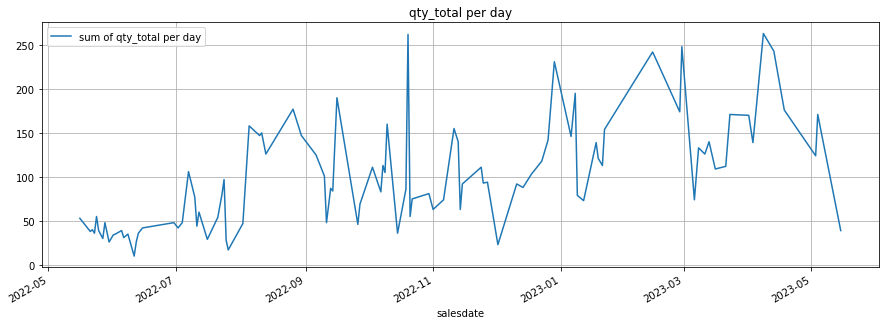

In [12]:
qty_per_day.plot(style='-',
                figsize=(15, 5),
                color=color_pal[0],
                title='qty_total per day',
                grid=True,
                legend=True)

- Based on the graph above, there is no pattern of data that represents seasonality. But there is a slightly positive trend

In [13]:
qty_per_day["day"] = qty_per_day.index.weekday
qty_per_day.head()

,sum of qty_total per day,day
salesdate,,
2022-05-16,53,0
2022-05-21,38,5
2022-05-22,40,6
2022-05-23,36,0
2022-05-24,55,1


In [14]:
qty_per_day.describe()

,sum of qty_total per day,day
count,101.000000,101.000000
mean,99.782178,2.871287
std,61.766432,2.115010
min,10.000000,0.000000
25%,47.000000,1.000000
50%,88.000000,3.000000
75%,140.000000,5.000000
max,263.000000,6.000000


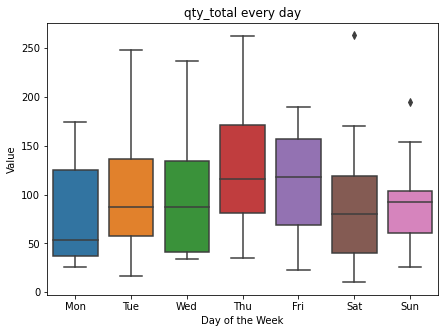

In [15]:
plt.figure(figsize=(7, 5))
sns.boxplot(x = 'day', y = 'sum of qty_total per day', data = qty_per_day)
plt.xlabel('Day of the Week')
plt.ylabel('Value')
plt.title('qty_total every day')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

- The outliers for the average daily total sales are relatively small, indicating that the sales distribution for each day is quite uniform
- The highest average total sales are found on Thursdays.

In [16]:
qty_per_week = qty_per_day.resample("W")[["sum of qty_total per day"]].sum().copy()
qty_per_week.rename(columns={"sum of qty_total per day":"sum of qty_total per week"},inplace = True)

In [17]:
qty_per_week["week"] = (qty_per_week.index.day - 1) // 7 + 1

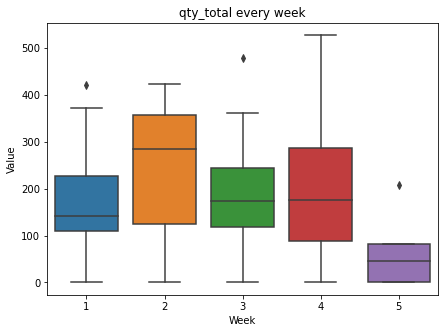

In [18]:
plt.figure(figsize=(7, 5))
sns.boxplot(x = 'week', y = 'sum of qty_total per week', data = qty_per_week)
plt.xlabel('Week')
plt.ylabel('Value')
plt.title('qty_total every week')
plt.show()

- The outliers for the average weekly total sales are small enough, indicating that the sales distribution for each week is relatively uniform.
- The highest average total sales are found in the second week.

## Promo Analysis

In [26]:
df_promo = df[["menuname","menu_group","qty_total"]].copy()

In [27]:
#get FS and B1G1 code from menuname using regex 
patternFS = r'^((\[).+(\])).*'
df_promo['FS'] = df_promo['menuname'].str.contains(patternFS)

patternB1G1 = r'(B1G1)'
df_promo['B1G1'] = df_promo['menuname'].str.contains(patternB1G1)

C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/1124866361.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df_promo['FS'] = df_promo['menuname'].str.contains(patternFS)
C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/1124866361.py:6: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df_promo['B1G1'] = df_promo['menuname'].str.contains(patternB1G1)


In [28]:
df_promo  = df_promo.pivot_table(values=["qty_total","FS","B1G1"], index='salesdate', aggfunc='sum')
df_promo.rename(columns = {"FS":"FS_total","B1G1":"B1G1_total"},inplace=True)
df_promo.head(3) # data frame that represent total flash sale and buy 1 get 1 tags that are used each day

,B1G1_total,FS_total,qty_total
salesdate,,,
2022-05-16,0,0,53
2022-05-21,0,0,38
2022-05-22,0,0,40


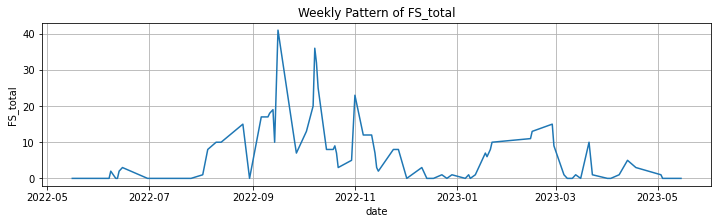

In [29]:
plt.figure(figsize=(12, 3))
plt.plot(df_promo.index, df_promo['FS_total'])
plt.xlabel('date')
plt.ylabel('FS_total')
plt.title('Weekly Pattern of FS_total')
plt.grid(True)
plt.show()

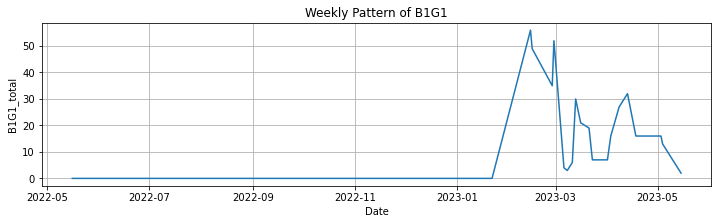

In [31]:
plt.figure(figsize=(12, 3))
plt.plot(df_promo.index, df_promo['B1G1_total'])
plt.xlabel('Date')
plt.ylabel('B1G1_total')
plt.title('Weekly Pattern of B1G1')
plt.grid(True)
plt.show()

- B1G1 occur after 2023-01

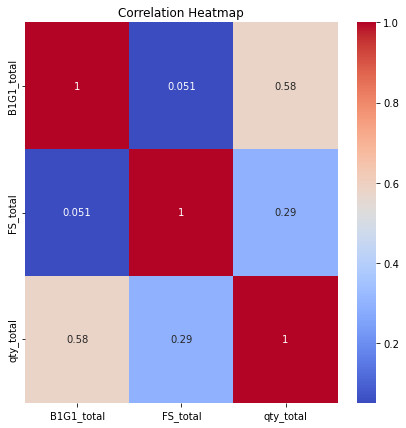

In [33]:
corr_matrix = df_promo.corr()

plt.figure(figsize=(7, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

- There is a positive correlation between qty_total and FS_total and B1G1, indicating that qty_total is influenced by FS and B1G1.

# Modelling for demand forecasting model of specific menu_group

## XGBoost

XGBoost is used because its effectiveness in handling time series forecasting problem

### Preprocessing

In [40]:
def preprocess_feature(df,menu_group):
    df = df[df.menu_group == menu_group].copy()
    
    patternFS = r'^((\[).+(\])).*'
    df['FS'] = df['menuname'].str.contains(patternFS)
    patternB1G1 = r'(B1G1)'
    df['B1G1'] = df['menuname'].str.contains(patternB1G1)
    
    df.drop(columns=['menuid','menuname','menu_group'],axis = 1,inplace=True)
    
    df_weekly = df.resample("W").sum()
    
    # split X and y
    y = df_weekly['qty_total'].copy()
    X = df_weekly.copy()
    return X, y

In [538]:
"""
splitting data: 70% train 30% test for dataset of menu_group = Gyudon Aburi with Miso Mayo & Sambal Korek
"""
X,y = preprocess_feature(df,"Gyudon Aburi with Miso Mayo & Sambal Korek")

trainX, testX,trainY, testY = train_test_split(X,y,test_size=0.3,shuffle=False)
print(f"trainX: {trainX.shape} | trainY: {trainY.shape}")
print(f"testX : {testX.shape} | testY : {testY.shape}")

trainX: (21, 3) | trainY: (21,)
testX : (9, 3) | testY : (9,)


C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/2434069213.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['FS'] = df['menuname'].str.contains(patternFS)
C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/2434069213.py:7: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['B1G1'] = df['menuname'].str.contains(patternB1G1)


In [525]:
trainX.head()

,qty_total,FS,B1G1
salesdate,,,
2022-10-16,1,0,0
2022-10-23,7,0,0
2022-10-30,0,0,0
2022-11-06,1,1,0
2022-11-13,9,0,0


In [527]:
trainY.head()

salesdate
2022-10-16    1
2022-10-23    7
2022-10-30    0
2022-11-06    1
2022-11-13    9
Freq: W-SUN, Name: qty_total, dtype: int64

In [539]:
scaler = MinMaxScaler()

trainX_scaled = scaler.fit_transform(trainX)
testX_scaled = scaler.transform(testX)

### Training

In [540]:
def training_model(X,y,params={}):
    dTrain = xgb.DMatrix(data=X, label=y)    
    model = xgb.train(params, dTrain)
    
    return model

In [541]:
def evaluation_model(model,trainY,testY,testX,verbose=False):
    dTest = xgb.DMatrix(data=testX)
    yPred = model.predict(dTest)
    mae = mean_absolute_error(testY, yPred)

    df_eval = testY.to_frame()

    df_eval['qty_total_pred'] = y_pred[1:]
    
    if(verbose):   
        print(f"MAE {mae}", end="\n")
        print(df_eval)

        plt.figure(figsize=(10, 5))
        plt.plot(trainY, color='blue', label = 'qty_total_Train')
        plt.title("Graph qty_total actual vs xgboost prediction")
        plt.xlabel("date")
        plt.ylabel("qty_total")
        plt.plot(df_eval['qty_total'], color='orange', label = 'qty_total_Test')
        plt.plot(df_eval['qty_total_pred'], color='green', label = 'qty_total_pred')
        plt.legend()
    return df_eval,mae

MAE 0.11134870927586842
            qty_total  qty_total_pred
salesdate                            
2023-03-12          5        5.000414
2023-03-19          1        1.000091
2023-03-26          2        1.999984
2023-04-02          0        0.000301
2023-04-09          2        1.999984
2023-04-16          1        1.000091
2023-04-23          2        1.999984
2023-04-30          0        0.000301
2023-05-07          6        6.999685


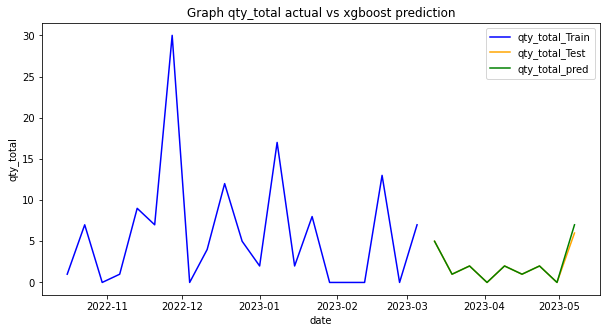

In [542]:
#only lr rate and max_depth
params = {
    'max_depth': 9,
    'learning_rate': 1.68,
}
model = training_model(trainX_scaled, trainY, params)
df_eval,mae = evaluation_model(model,trainY,testY,testX_scaled,True)

- the error rate is small so the model good to be deployed
- learning rate and max_depth were chosen because these hyperparameters influence a lot to the minimum error than any hyperparameter (e.g: gamma,min_child_weight) based on trial shown below,
- Only lr rate, max dept; MAE : 0.11
- lr rate, max depth, gamma, min_child_weight; MAE: 0.11


In [534]:
params = {
    'max_depth': 9,
    'learning_rate': 1.68,
    'gamma':0.00001,
    "min_child_weight":0
}

model = training_model(trainX_scaled, trainY, params)
evaluation_model(model,trainY,testY,testX_scaled)

(            qty_total  qty_total_pred
 salesdate                            
 2023-03-12          5        5.000414
 2023-03-19          1        1.000091
 2023-03-26          2        1.999984
 2023-04-02          0        0.000301
 2023-04-09          2        1.999984
 2023-04-16          1        1.000091
 2023-04-23          2        1.999984
 2023-04-30          0        0.000301
 2023-05-07          6        6.999685,
 0.11174116821752654)

### Tuning

In [535]:
def black_box_XGBoost(learning_rate, max_depth):
    # input params
    params = {
        'objective': 'reg:squarederror',
        'learning_rate':learning_rate,
        'max_depth': int(max_depth),
    }

    # train
    dTrain = xgb.DMatrix(data=trainX_scaled, label=trainY) 
    dTest = xgb.DMatrix(data=testX_scaled)
    model = xgb.train(params, dTrain)

    # predict
    yPred = model.predict(dTest)

    # evaluate
    mae = mean_absolute_error(testY, yPred)

    return -mae

In [536]:
param_bounds = {
    'learning_rate': (0.01, 2),
    'max_depth': (3, 10),
}

optimizer = BayesianOptimization(
    f=black_box_XGBoost,
    pbounds=param_bounds,
    random_state=1,
)

In [520]:
optimizer.maximize(
    init_points=3, 
    n_iter=100, 
)

|   iter    |  target   | learni... | max_depth |
-------------------------------------------------
| 1         | -0.1124   | 0.8399    | 8.042     |
| 2         | -1.689    | 0.01023   | 5.116     |
| 3         | -0.1545   | 0.302     | 3.646     |
| 4         | -0.1767   | 0.2265    | 5.582     |
| 5         | -0.1113   | 1.662     | 7.621     |
| 6         | -0.1418   | 0.3071    | 7.402     |
| 7         | -0.2302   | 0.1813    | 8.311     |
| 8         | -0.1351   | 0.7973    | 4.13      |
| 9         | -0.1117   | 1.777     | 6.13      |
| 10        | -0.1123   | 0.8703    | 5.464     |
| 11        | -0.1116   | 1.224     | 5.75      |
| 12        | -0.1129   | 1.118     | 5.665     |
| 13        | -0.1421   | 0.3054    | 5.847     |
| 14        | -0.4083   | 0.1429    | 6.74      |
| 15        | -0.1308   | 0.685     | 4.924     |
| 16        | -0.1115   | 1.795     | 6.114     |
| 17        | -0.1446   | 0.3175    | 5.848     |
| 18        | -0.1123   | 1.254     | 4.854     |


| 100       | -0.1236   | 0.5598    | 6.259     |
| 101       | -1.693    | 0.01      | 6.065     |
| 102       | -0.1117   | 1.116     | 7.054     |
| 103       | -0.1128   | 1.237     | 4.307     |


In [423]:
best_hyperparameters = optimizer.max['params']
best_hyperparameters

{'learning_rate': 1.686979933603153, 'max_depth': 9.048849097940542}

### Save Model to .json

In [537]:
"""for development process all menu group using the same params for each menu_group 
because limited of time for tuning all model for each menu_group"""

params = {
    'max_depth': 9,
    'learning_rate': 1.68,
}

for menu_group in menu_grup_unique:
    path = f"../api/savedmodel/{menu_group}.json"
    try:

        X,y = preprocess_feature(df,menu_group)
        trainX, testX,trainY, testY = train_test_split(X,y,test_size=0.3,shuffle=False)
        scaler = MinMaxScaler()
        trainX_scaled = scaler.fit_transform(trainX)
        testX_scaled = scaler.transform(testX)
        
        model = training_model(trainX_scaled,trainY,params)
        __, mae = evaluation_model(model,trainY,testY,testX_scaled,False)
        model.save_model(path)
        print(f"{menu_group} mae: {mae}")
    except:
        print(f"error created model:  {menu_group}")

C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/2434069213.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['FS'] = df['menuname'].str.contains(patternFS)
C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/2434069213.py:7: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['B1G1'] = df['menuname'].str.contains(patternB1G1)
C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/2434069213.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['FS'] = df['menuname'].str.contains(patternFS)
C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/2434069213.py:7: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['B1G1'] = df['menuname'].str.contains(patternB1G1)
C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/2434069213.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.

error created model:  Spicy Gyudon
error created model:  0
error created model:  Sei Sapi sambal matah
error created model:  Sei Ayam sambal matah
error created model:  Sei Sapi sambal andaliman
error created model:  Sei Sapi sambal rica


C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/2434069213.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['FS'] = df['menuname'].str.contains(patternFS)
C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/2434069213.py:7: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['B1G1'] = df['menuname'].str.contains(patternB1G1)
C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/2434069213.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['FS'] = df['menuname'].str.contains(patternFS)
C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/2434069213.py:7: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['B1G1'] = df['menuname'].str.contains(patternB1G1)
C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/2434069213.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.

error created model:  Extra Item
error created model:  Sei Sapi Belimbing Wuluh 
error created model:  Miso Gyudon
error created model:  Mentai Gyudon
error created model:  Sei Ayam Longboard
error created model:  Korean Fried Chicken Wings


C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/2434069213.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['FS'] = df['menuname'].str.contains(patternFS)
C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/2434069213.py:7: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['B1G1'] = df['menuname'].str.contains(patternB1G1)
C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/2434069213.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['FS'] = df['menuname'].str.contains(patternFS)
C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/2434069213.py:7: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['B1G1'] = df['menuname'].str.contains(patternB1G1)
C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/2434069213.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.

Sei Sultan sambal rica mae: 0.2226270904454092
error created model:  Sei Sultan sambal matah
error created model:  Sei Ayam sambal andaliman
error created model:  Sei Sapi Premium Longboard
error created model:  Sei Sultan sambal andaliman
error created model:  Sei Sultan Belimbing Wuluh
error created model:  Sei Sapi sambal Embe


C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/2434069213.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['FS'] = df['menuname'].str.contains(patternFS)
C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/2434069213.py:7: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['B1G1'] = df['menuname'].str.contains(patternB1G1)
C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/2434069213.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['FS'] = df['menuname'].str.contains(patternFS)
C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/2434069213.py:7: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['B1G1'] = df['menuname'].str.contains(patternB1G1)
C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/2434069213.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.

error created model:  Sei Ayam Belimbing Wuluh
error created model:  Spaghetti Spicy Seafood Mentai
error created model:  Truffle Gyudon
error created model:  Sei Ayam sambal rica
error created model:  Spaghetti with Truffle Cream and Chicken
error created model:  Buttermilk Chicken
error created model:  Black Pepper Chicken


C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/2434069213.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['FS'] = df['menuname'].str.contains(patternFS)
C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/2434069213.py:7: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['B1G1'] = df['menuname'].str.contains(patternB1G1)
C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/2434069213.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['FS'] = df['menuname'].str.contains(patternFS)
C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/2434069213.py:7: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['B1G1'] = df['menuname'].str.contains(patternB1G1)
C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/2434069213.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.

error created model:  Kung Pao Chicken
error created model:  Crispy Cereal Chicken
error created model:  Spaghetti Cakalang Cabe Ijo
error created model:  Spaghetti Gulai Ayam
Spaghetti Bolognese Brulee mae: 0.11307419407077962
error created model:  Classic Mentega Chicken
error created model:  Spaghetti Chicken & Mushroom Crema


C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/2434069213.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['FS'] = df['menuname'].str.contains(patternFS)
C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/2434069213.py:7: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['B1G1'] = df['menuname'].str.contains(patternB1G1)
C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/2434069213.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['FS'] = df['menuname'].str.contains(patternFS)
C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/2434069213.py:7: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['B1G1'] = df['menuname'].str.contains(patternB1G1)
C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/2434069213.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.

error created model:  Nasei Bungkus Ayam Padang
error created model:  Spaghetti Smoked Beef Garlic Butter
error created model:  Sei Ayam Juicy
error created model:  Spaghetti Prawn/Chicken Aglio Olio
error created model:  Ninniku Gyudon
error created model:  Teriyaki Gyudon
Gyudon Aburi with Miso Mayo & Sambal Korek mae: 0.11134870927586842
error created model:  Spaghetti with Truffle Cream & Chicken
error created model:  Spaghetti Carbonara Smoked Beef


C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/2434069213.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['FS'] = df['menuname'].str.contains(patternFS)
C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/2434069213.py:7: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['B1G1'] = df['menuname'].str.contains(patternB1G1)
C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/2434069213.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['FS'] = df['menuname'].str.contains(patternFS)
C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/2434069213.py:7: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['B1G1'] = df['menuname'].str.contains(patternB1G1)
C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/2434069213.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.

error created model:  Nasei Bungkus Sapi Padang
Chicken Katsu Don mae: 2.222636125360926
error created model:  Nachos with Cajun Sauce
error created model:  Sweet and Spicy Chicken
error created model:  Nachos with Sambal
error created model:  Chicken Skin
error created model:  Spaghetti Samyang Carbonara


C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/2434069213.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['FS'] = df['menuname'].str.contains(patternFS)
C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/2434069213.py:7: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['B1G1'] = df['menuname'].str.contains(patternB1G1)
C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/2434069213.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['FS'] = df['menuname'].str.contains(patternFS)
C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/2434069213.py:7: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['B1G1'] = df['menuname'].str.contains(patternB1G1)
C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/2434069213.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.

error created model:  Bumbu Cabe Garam Chicken
error created model:  Korean Hot Sauce Chicken
error created model:  Beef Gyudon Aburi
error created model:  Classic Spaghetti Bolognese
error created model:  Caramelized Butter Chicken
error created model:  Nachos with Bolognese Sauce
error created model:  Sei Sapi Platter
error created model:  Spaghetti Sausage Alfredo Junior
error created model:  Sei Ayam Platter
error created model:  Chicken Dice Kungpao
error created model:  Sei Sultan Platter
error created model:  Spaghetti Chicken Singapore Laksa
error created model:  Spaghetti Chicken Soto
error created model:  Spaghetti Chicken Malaysian Kari


C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/2434069213.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['FS'] = df['menuname'].str.contains(patternFS)
C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/2434069213.py:7: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['B1G1'] = df['menuname'].str.contains(patternB1G1)
C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/2434069213.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['FS'] = df['menuname'].str.contains(patternFS)
C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/2434069213.py:7: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  df['B1G1'] = df['menuname'].str.contains(patternB1G1)
C:\Users\Wilson\AppData\Local\Temp/ipykernel_31672/2434069213.py:5: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.

list of model that are succesfully created:
- Chicken Katsu Don
- Gyudon Aburi with Miso Mayo & Sambal Korek
- Sei Sultan sambal rica
- Spaghetti Bolognese Brulee

the othe menu_group model is failed to be generated because the data too small


## LSTM

In [543]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)